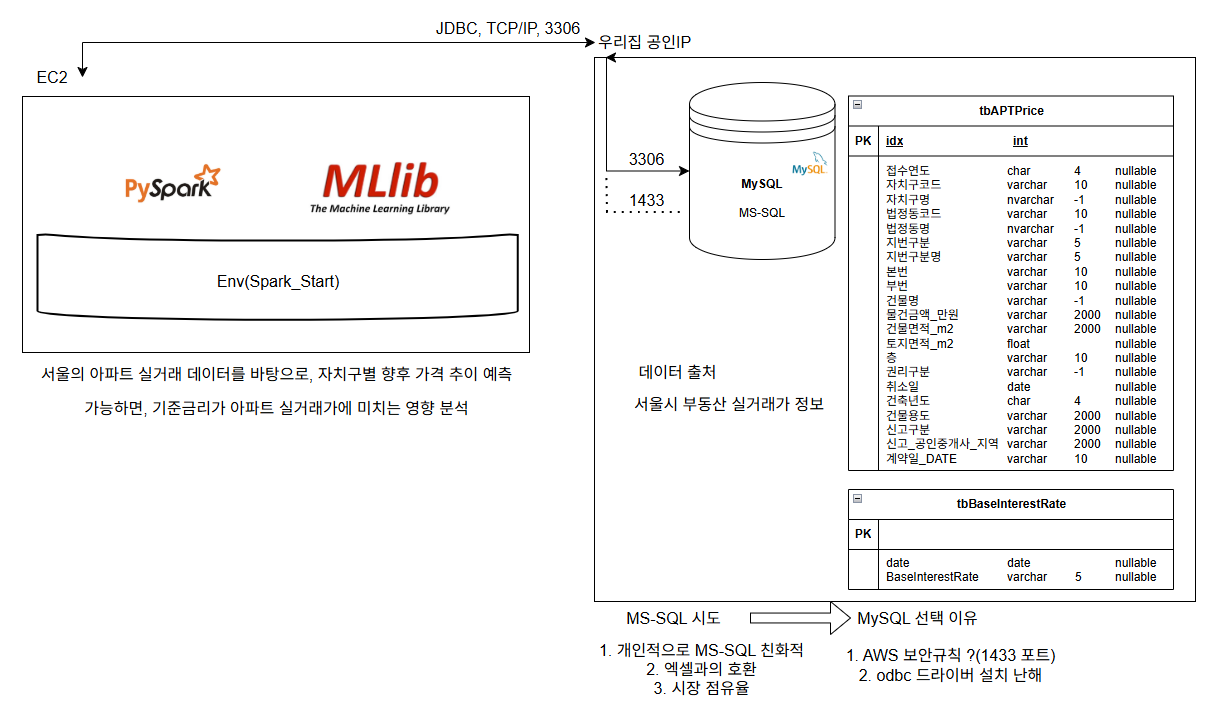

# 목표
- 서울의 아파트 실거래 데이터를 바탕으로, 자치구별 향후 가격 추이 예측

# 데이터
- 서울시 부동산 실거래가 정보  

# 데이터 URL
- https://data.seoul.go.kr/dataList/OA-21275/S/1/datasetView.do

# 계획
- 개발환경 구축
    - 위의 사진 참고 -- 완료
    - DB 연결 -- 완료

- 전처리
    - NULL, 0 등 이상치 수정 -- 진행 중

- 학습
- 예측

In [285]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, sum, round, mean, lit, concat

# import pyodbc

import os

from dotenv import load_dotenv

In [286]:
load_dotenv()

host_ip = os.getenv('host_ip')
DATABASE = os.getenv('DATABASE')
user_id = os.getenv('user_id')
user_password = os.getenv('user_password')

# 환경변수 설정
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/local/lib/mysql-connector-java-5.1.49-bin.jar pyspark-shell'

In [287]:
ss = SparkSession\
            .builder\
            .appName('MySQL')\
            .config('spark.executor.memory', '6g')\
            .config('spark.driver.memory', '6g')\
            .getOrCreate()

In [288]:
mysql_url = f'jdbc:mysql://{host_ip}:3306/{DATABASE}'

In [289]:
df_tbAPTPrice = ss.read.format('jdbc')\
            .options(
                url = mysql_url
                , driver = 'com.mysql.jdbc.Driver'
                , dbtable = 'tbAPTPrice'
                , user = user_id
                , password = user_password
                    )\
        .load()

df_tbAPTPrice.show(10)

Wed Dec 18 18:21:23 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Wed Dec 18 18:21:24 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

+--------+----------+--------+----------+--------+--------+----------+----+----+-------------------+-------------+-----------+-----------+---+--------+------+--------+----------+--------+--------------------+-----------+---+
|접수연도|자치구코드|자치구명|법정동코드|법정동명|지번구분|지번구분명|본번|부번|             건물명|물건금액_만원|건물면적_m2|토지면적_m2| 층|권리구분|취소일|건축년도|  건물용도|신고구분|신고_공인중개사_지역|계약일_DATE|idx|
+--------+----------+--------+----------+--------+--------+----------+----+----+-------------------+-------------+-----------+-----------+---+--------+------+--------+----------+--------+--------------------+-----------+---+
|    2017|     11710|  송파구|     10500|  석촌동|       1|      대지|0282|0000|           은하빌라|        42000|      73.12|         36|  3|        |      |    2004|연립다세대|        |                    | 2017-08-08|  1|
|    2017|     11560|영등포구|     13200|  신길동|        |          |    |    |                   |        60000|     127.44|         86|   |        |      |    1992|단독다가구|        |                    | 2017

In [290]:
df_tbBaseInterestRate = ss.read.format('jdbc')\
            .options(
                url = mysql_url
                , driver = 'com.mysql.jdbc.Driver'
                , dbtable = 'tbBaseInterestRate'
                , user = user_id
                , password = user_password
                    )\
        .load()

df_tbBaseInterestRate.show(10)

Wed Dec 18 18:21:40 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Wed Dec 18 18:21:40 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

+----------+----------------+
|      date|BaseInterestRate|
+----------+----------------+
|2024-11-28|               3|
|2024-10-11|            3.25|
|2023-01-13|             3.5|
|2022-11-24|            3.25|
|2022-10-12|               3|
|2022-08-25|             2.5|
|2022-07-13|            2.25|
|2022-05-26|            1.75|
|2022-04-14|             1.5|
|2022-01-14|            1.25|
+----------+----------------+
only showing top 10 rows



In [291]:
df_tbAPTPrice.printSchema()

root
 |-- 접수연도: string (nullable = true)
 |-- 자치구코드: string (nullable = true)
 |-- 자치구명: string (nullable = true)
 |-- 법정동코드: string (nullable = true)
 |-- 법정동명: string (nullable = true)
 |-- 지번구분: string (nullable = true)
 |-- 지번구분명: string (nullable = true)
 |-- 본번: string (nullable = true)
 |-- 부번: string (nullable = true)
 |-- 건물명: string (nullable = true)
 |-- 물건금액_만원: string (nullable = true)
 |-- 건물면적_m2: string (nullable = true)
 |-- 토지면적_m2: string (nullable = true)
 |-- 층: string (nullable = true)
 |-- 권리구분: string (nullable = true)
 |-- 취소일: string (nullable = true)
 |-- 건축년도: string (nullable = true)
 |-- 건물용도: string (nullable = true)
 |-- 신고구분: string (nullable = true)
 |-- 신고_공인중개사_지역: string (nullable = true)
 |-- 계약일_DATE: string (nullable = true)
 |-- idx: integer (nullable = true)



### 컬럼 이름 영어로 수정

In [292]:
renamed_columns = ['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name', 'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name', 'building_price', 'building_size', 'land_size', 'floor', 'right_gubun', 'cancel_date', 'building_year', 'building_usage', 'singo_gubun', 'agent_area',  'contract_date', 'idx']

if len(df_tbAPTPrice.columns) == len(renamed_columns):
    renamed_columns_dict = {i : j for i,j in zip(df_tbAPTPrice.columns, renamed_columns)}

for num, i in enumerate(df_tbAPTPrice.columns):
    if i == list(renamed_columns_dict.keys())[num]:
        df_tbAPTPrice = df_tbAPTPrice.withColumnRenamed(i, list(renamed_columns_dict.values())[num])

df_tbAPTPrice.columns

['sumbit_year',
 'jachigu_code',
 'jachigu_name',
 'law_code',
 'law_name',
 'jibun_gubun',
 'jibun_name',
 'real_num',
 'extra_num',
 'building_name',
 'building_price',
 'building_size',
 'land_size',
 'floor',
 'right_gubun',
 'cancel_date',
 'building_year',
 'building_usage',
 'singo_gubun',
 'agent_area',
 'contract_date',
 'idx']

In [293]:
df_tbAPTPrice.count()

Wed Dec 18 18:21:56 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.


856311

## 전처리

### 학습에 불필요한 컬럼 삭제

In [294]:
df_tbAPTPrice = \
df_tbAPTPrice.drop('real_num'
                   , 'extra_num'
                   , 'land_size'
                   , 'right_gubun'
                   , 'cancel_date'
                   , 'singo_gubun'
                   , 'agent_area'
                   , 'contract_date')

df_tbAPTPrice.printSchema()

root
 |-- sumbit_year: string (nullable = true)
 |-- jachigu_code: string (nullable = true)
 |-- jachigu_name: string (nullable = true)
 |-- law_code: string (nullable = true)
 |-- law_name: string (nullable = true)
 |-- jibun_gubun: string (nullable = true)
 |-- jibun_name: string (nullable = true)
 |-- building_name: string (nullable = true)
 |-- building_price: string (nullable = true)
 |-- building_size: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- building_year: string (nullable = true)
 |-- building_usage: string (nullable = true)
 |-- idx: integer (nullable = true)



### 결측치, 이상치 확인

#### 결측치(NULL) 확인

In [295]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i).isNull() | isnan(i),1)\
            .otherwise(0)
            )\
            .alias(i + '_nulls') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

Wed Dec 18 18:22:06 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.


{'sumbit_year_nulls': 0,
 'jachigu_code_nulls': 0,
 'jachigu_name_nulls': 0,
 'law_code_nulls': 0,
 'law_name_nulls': 0,
 'jibun_gubun_nulls': 0,
 'jibun_name_nulls': 0,
 'building_name_nulls': 0,
 'building_price_nulls': 0,
 'building_size_nulls': 0,
 'floor_nulls': 0,
 'building_year_nulls': 3711,
 'building_usage_nulls': 0,
 'idx_nulls': 0}

In [296]:
df_tbAPTPrice.selectExpr('*')\
                .where('building_year is NULL')\
                .show(10)

Wed Dec 18 18:22:30 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.


+-----------+------------+------------+--------+---------+-----------+----------+-------------------+--------------+-------------+-----+-------------+--------------+----+
|sumbit_year|jachigu_code|jachigu_name|law_code| law_name|jibun_gubun|jibun_name|      building_name|building_price|building_size|floor|building_year|building_usage| idx|
+-----------+------------+------------+--------+---------+-----------+----------+-------------------+--------------+-------------+-----+-------------+--------------+----+
|       2017|       11500|      강서구|   10300|   화곡동|          1|      대지|         남광아파트|         18000|        51.89|   14|         null|      오피스텔| 142|
|       2017|       11500|      강서구|   10300|   화곡동|          1|      대지|         남광아파트|         18000|        51.89|   10|         null|      오피스텔|1233|
|       2017|       11200|      성동구|   11400|성수동1가|           |          |                   |         75000|       128.51|     |         null|    단독다가구|2346|
|       2017|       

In [297]:
# 자치구, 법정동, 건물용도별 평균 값의 정수 부분을 건물연식으로 넣어주자
# 주택은 한 두 군데만 짓기보단 마을, 단지별로 싹 착공, 재건축하니, 비슷한 지역의 비슷한 매물이 비슷한 연식일 것이라는 가정
tmp_df = df_tbAPTPrice.withColumn('building_year', col('building_year').cast('double'))\
            .groupby('jachigu_code', 'law_code', 'building_usage')\
            .agg(mean('building_year').alias('avg_building_year'))\
            .withColumn('avg_building_year', col('avg_building_year').cast('int'))
            
tmp_df.show(10)

Wed Dec 18 18:22:36 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.


+------------+--------+--------------+-----------------+
|jachigu_code|law_code|building_usage|avg_building_year|
+------------+--------+--------------+-----------------+
|       11560|   11100|    단독다가구|             1982|
|       11230|   10900|        아파트|             1771|
|       11530|   10700|        아파트|             1983|
|       11200|   11500|        아파트|             2002|
|       11440|   11500|      오피스텔|             2003|
|       11560|   12900|    연립다세대|             2014|
|       11200|   12200|    연립다세대|             2013|
|       11545|   10300|      오피스텔|             2016|
|       11680|   11400|    연립다세대|             2000|
|       11170|   12900|    연립다세대|             1976|
+------------+--------+--------------+-----------------+
only showing top 10 rows



In [298]:
df_tbAPTPrice = df_tbAPTPrice.join(tmp_df, on = ['jachigu_code', 'law_code', 'building_usage'], how = 'left')\
                            .withColumn('building_year'
                                          , when(col('building_year').isNull(), col('avg_building_year'))\
                           .otherwise(col('building_year'))
                                        )\
                            .persist()\
                            
                   

In [299]:
df_tbAPTPrice.selectExpr('*')\
                .where('building_year is NULL')\
                .show(10)

Wed Dec 18 18:22:45 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Wed Dec 18 18:22:45 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+
|jachigu_code|law_code|building_usage|sumbit_year|jachigu_name|law_name|jibun_gubun|jibun_name|building_name|building_price|building_size|floor|building_year|idx|avg_building_year|
+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+
+------------+--------+--------------+-----------+------------+--------+-----------+----------+-------------+--------------+-------------+-----+-------------+---+-----------------+



In [300]:
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

#### 0인 값 확인 및 처리

In [301]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i) == 0 ,1)\
            .otherwise(0)
            )\
            .alias(i + '_0') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'jachigu_code_0': 0,
 'law_code_0': 0,
 'building_usage_0': 0,
 'sumbit_year_0': 0,
 'jachigu_name_0': 0,
 'law_name_0': 0,
 'jibun_gubun_0': 0,
 'jibun_name_0': 0,
 'building_name_0': 26,
 'building_price_0': 0,
 'building_size_0': 0,
 'floor_0': 3,
 'building_year_0': 16513,
 'idx_0': 0,
 'avg_building_year_0': 38}

In [302]:
ss.sql('''
        SELECT
            count(building_year)
        FROM tmp_view
        WHERE building_year = 0
''')\
.show()


+--------------------+
|count(building_year)|
+--------------------+
|               16513|
+--------------------+



In [303]:
df_tbAPTPrice = df_tbAPTPrice.join(tmp_df, on = ['jachigu_code', 'law_code', 'building_usage'], how = 'left')\
                            .withColumn('building_year'
                                          , when(col('building_year') ==0, 'avg_building_year')\
                           .otherwise(col('building_year'))
                                        )\
                            .persist()
                   

In [304]:
df_tbAPTPrice.filter(col('building_year') == 0)\
            .select('jachigu_name', 'law_name', 'building_name')\
            .show()

Wed Dec 18 18:23:22 KST 2024 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.


+------------+--------+-------------+
|jachigu_name|law_name|building_name|
+------------+--------+-------------+
+------------+--------+-------------+



In [305]:
df_tbAPTPrice = df_tbAPTPrice.drop('avg_building_year')
df_tbAPTPrice.persist()

DataFrame[jachigu_code: string, law_code: string, building_usage: string, sumbit_year: string, jachigu_name: string, law_name: string, jibun_gubun: string, jibun_name: string, building_name: string, building_price: string, building_size: string, floor: string, building_year: string, idx: int]

In [306]:
tmp = df_tbAPTPrice.select(
        [sum(
            when(
                col(i) == 0 ,1)\
            .otherwise(0)
            )\
            .alias(i + '_0') for i in df_tbAPTPrice.columns
        ]
    ).collect()
    
tmp[0].asDict()

{'jachigu_code_0': 0,
 'law_code_0': 0,
 'building_usage_0': 0,
 'sumbit_year_0': 0,
 'jachigu_name_0': 0,
 'law_name_0': 0,
 'jibun_gubun_0': 0,
 'jibun_name_0': 0,
 'building_name_0': 26,
 'building_price_0': 0,
 'building_size_0': 0,
 'floor_0': 3,
 'building_year_0': 0,
 'idx_0': 0}

#### building_name 빈거 처리

In [307]:
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

In [308]:
ss.sql('''
        SELECT
        
            jachigu_code
            , law_code
            , building_usage
            , MAX(jachigu_name)
            , MAX(law_name)
            , MAX(building_usage)
            , MAX(building_name)
            
        FROM tmp_view
        WHERE building_name = 0
        GROUP BY jachigu_code, law_code, building_usage
''').show()

+------------+--------+--------------+-----------------+-------------+-------------------+------------------+
|jachigu_code|law_code|building_usage|max(jachigu_name)|max(law_name)|max(building_usage)|max(building_name)|
+------------+--------+--------------+-----------------+-------------+-------------------+------------------+
|       11620|   10100|      오피스텔|           관악구|       봉천동|           오피스텔|                 .|
|       11620|   10200|      오피스텔|           관악구|       신림동|           오피스텔|                 .|
|       11560|   11400|      오피스텔|         영등포구|    당산동4가|           오피스텔|                 .|
+------------+--------+--------------+-----------------+-------------+-------------------+------------------+



In [309]:
df_tbAPTPrice.select('building_name')\
            .where('building_name == 0')\
            .count()

26

In [310]:
df_tbAPTPrice = df_tbAPTPrice.withColumn('building_name'
                                        , when(col('building_name') == 0
                                               , concat(col('jachigu_name'), lit('_'), col('law_name'), lit('_'), col('building_usage'), lit('_'), lit('이름없음')))\
                            .otherwise(col('building_name'))\
                                        )\
                            .persist()

In [311]:
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

### 건물연식이 1954년 미만인 건물은 제거 + floor가 0인 건물 모두 제거됨
- 1953년 한국전쟁 정전 이후 건물만 반영(1953년 7월 27일)
- 1634건 삭제

In [312]:
df_tbAPTPrice = df_tbAPTPrice.selectExpr('*')\
                            .where('building_year >= 1954')\
                            .persist()                

In [313]:
df_tbAPTPrice.createOrReplaceTempView('tmp_view')

In [314]:
ss.stop()

### 컬럼별 결측치 확인

In [147]:
df.select('jachigu_name')\
    .where('jachigu_name IS NULL')\
    .show()


# 확인 결과 자치구명 NULL의 1건은 미아동이며, 2020년 2차 행복주택 입주자 모집에 따르면 미아동이 맞음을 확인할 수 있음
# 이에 다른 미아동처럼 강북구 코드인 11305으로 업데이트
# 출처 : https://image.ebunyang.co.kr/files/bunyang/pdf/uploadfile_202012283766287.pdf
# 출처 : https://www.code.go.kr/stdcode/regCodeL.do
df = df.select('jachigu_name')\
        .where('jachigu_name IS NULL')\
        .fillna('11305')

+------------+
|jachigu_name|
+------------+
|        null|
+------------+

+------------+
|jachigu_name|
+------------+
+------------+



In [ ]:
df.createOrReplaceTempView('tmp')

ss.sql('''
    SELECT
        *
    
    FROM tmp
    WHERE jachigu_name is NULL

''').show()

In [284]:
ss.stop()

### 쓰레기

In [8]:
config = {
    'server' : os.getenv('host_ip'),
    'database' : os.getenv('DATABASE'),
    'username' : os.getenv('user_id'),
    'password' : os.getenv('user_password'),
    'driver' : 'ODBC Driver 17 for SQL Server',
}
# JDBC URL 문자열 생성
jdbc_url = f"jdbc:sqlserver://{config['server']}:1433;databaseName={config['database']};"

# Spark JDBC 연결 설정
properties = {
    "user": config['username'],
    "password": config['password'],
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

print("JDBC URL:", jdbc_url)
print("JDBC Properties:", properties)


JDBC URL: jdbc:sqlserver://172.30.1.44:1433;databaseName=APT_Project;
JDBC Properties: {'user': 'APT_Project', 'password': 'APT_Project', 'driver': 'com.microsoft.sqlserver.jdbc.SQLServerDriver'}
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [9]:
# SparkSession 생성
ss = SparkSession.builder \
    .appName("PySpark MSSQL Example") \
    .config("spark.jars", "file:/C:/Users/YJ/Desktop/AllProjects/sqljdbc_12.8/kor/jars/mssql-jdbc-12.8.1.jre8.jar") \
    .getOrCreate()

print("Spark Session이 성공적으로 생성되었습니다!")

24/12/18 14:03:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Exception in thread "main" java.lang.IllegalArgumentException: java.net.URISyntaxException: Expected scheme-specific part at index 2: C:
	at org.apache.hadoop.fs.Path.initialize(Path.java:259)
	at org.apache.hadoop.fs.Path.<init>(Path.java:217)
	at org.apache.hadoop.fs.Path.<init>(Path.java:125)
	at org.apache.hadoop.fs.Globber.doGlob(Globber.java:229)
	at org.apache.hadoop.fs.Globber.glob(Globber.java:149)
	at org.apache.hadoop.fs.FileSystem.globStatus(FileSystem.java:2016)
	at org.apache.spark.deploy.DependencyUtils$.resolveGlobPath(DependencyUtils.scala:192)
	at org.apache.spark.deploy.DependencyUtils$.$anonfun$resolveGlobPaths$2(DependencyUtils.scala:147)
	at org.apache.spark.deploy.DependencyUtils$.$anonfun$resolveGlobPaths$2$adapted(DependencyUtils.scala:145)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:245

Exception: Java gateway process exited before sending its port number

In [44]:
config = {
    'server' : os.getenv('host_ip'),
    'database' : os.getenv('DATABASE'),
    'username' : os.getenv('user_id'),
    'password' : os.getenv('user_password'),
    'driver' : 'ODBC Driver 17 for SQL Server',
}
# JDBC URL 문자열 생성
jdbc_url = f"jdbc:sqlserver://{config['server']}:1433;databaseName={config['database']};"

# Spark JDBC 연결 설정
properties = {
    "user": config['username'],
    "password": config['password'],
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

print("JDBC URL:", jdbc_url)
print("JDBC Properties:", properties)
ss


ss.read.jdbc(
    url = jdbc_url,
    table = 'dbo.tbAPTPrice',
    properties = properties    
)\
.show()


JDBC URL: jdbc:sqlserver://172.30.1.44:1433;databaseName=APT_Project;
JDBC Properties: {'user': 'APT_Project', 'password': 'APT_Project', 'driver': 'com.microsoft.sqlserver.jdbc.SQLServerDriver'}


Py4JJavaError: An error occurred while calling o152.jdbc.
: java.lang.ClassNotFoundException: com.microsoft.sqlserver.jdbc.SQLServerDriver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:593)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:526)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:46)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:102)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:102)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:102)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:38)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:32)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:355)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:325)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$3(DataFrameReader.scala:307)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:307)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:225)
	at org.apache.spark.sql.DataFrameReader.jdbc(DataFrameReader.scala:340)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


### 쓰레기

### 쓰레기

In [ ]:
file_path = os.path.join(os.getcwd(), 'data', 'house_project_data/*.csv')
file_path2 = os.path.join(os.getcwd(), 'data', 'house_project_data/code/*.csv')

df = ss.read.csv(f'file:///{file_path}', inferSchema = True, header = True, encoding = 'cp949')
df

df_rate = ss.read.csv(f'file:///{file_path2}', inferSchema = True, header = True, encoding = 'cp949')
df_rate

In [144]:
## 로컬용
tmp_df1 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2017.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df2 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2018.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df3 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2019.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df4 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2020.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df5 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2021.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df6 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2022.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df7 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2023.csv', inferSchema = True, header = True, encoding = 'cp949')
tmp_df8 = ss.read.csv('./data/house_project_data/서울시 부동산 실거래가 정보_2024.csv', inferSchema = True, header = True, encoding = 'cp949')

df = tmp_df1\
    .union(tmp_df2)\
    .union(tmp_df3)\
    .union(tmp_df4)\
    .union(tmp_df5)\
    .union(tmp_df6)\
    .union(tmp_df7)\
    .union(tmp_df8)

df_rate = ss.read.csv('./data/house_project_data/code/korea_base_interest_rate.csv', inferSchema = True, header = True, encoding = 'cp949')

In [18]:
df.show(3, truncate = False)

+--------+----------+--------+----------+--------+--------+----------+----+----+----------+--------+--------------+------------+------------+---+--------+------+--------+----------+--------+------------------------------+
|접수연도|자치구코드|자치구명|법정동코드|법정동명|지번구분|지번구분명|본번|부번|건물명    |계약일  |물건금액(만원)|건물면적(㎡)|토지면적(㎡)|층 |권리구분|취소일|건축년도|건물용도  |신고구분|신고한 개업공인중개사 시군구명|
+--------+----------+--------+----------+--------+--------+----------+----+----+----------+--------+--------------+------------+------------+---+--------+------+--------+----------+--------+------------------------------+
|2017    |11740     |강동구  |10900     |천호동  |1       |대지      |0449|49  |힐탑프라자|20180310|8900          |20.48       |24.26       |16 |null    |null  |1994    |오피스텔  |null    |null                          |
|2017    |11260     |중랑구  |10400     |묵동    |1       |대지      |0243|110 |애플하우스|20180307|16500         |29.7        |16.84       |4  |null    |null  |2012    |연립다세대|null    |null                          |
|2017    |11680

In [78]:
df.printSchema()

root
 |-- 접수연도: integer (nullable = true)
 |-- 자치구코드: integer (nullable = true)
 |-- 자치구명: string (nullable = true)
 |-- 법정동코드: integer (nullable = true)
 |-- 법정동명: string (nullable = true)
 |-- 지번구분: integer (nullable = true)
 |-- 지번구분명: string (nullable = true)
 |-- 본번: string (nullable = true)
 |-- 부번: string (nullable = true)
 |-- 건물명: string (nullable = true)
 |-- 계약일: integer (nullable = true)
 |-- 물건금액(만원): integer (nullable = true)
 |-- 건물면적(㎡): double (nullable = true)
 |-- 토지면적(㎡): double (nullable = true)
 |-- 층: integer (nullable = true)
 |-- 권리구분: string (nullable = true)
 |-- 취소일: string (nullable = true)
 |-- 건축년도: string (nullable = true)
 |-- 건물용도: string (nullable = true)
 |-- 신고구분: string (nullable = true)
 |-- 신고한 개업공인중개사 시군구명: string (nullable = true)



In [19]:
df.count()

1035346

In [146]:
renamed_columns = ['sumbit_year', 'jachigu_code', 'jachigu_name', 'law_code', 'law_name', 'jibun_gubun', 'jibun_name', 'real_num', 'extra_num', 'building_name', 'contract_date', 'building_price', 'building_size', 'land_size', 'floor', 'right_gubun', 'cancel_date', 'building_year', 'building_usage', 'singo_gubun', 'agent_area']

if len(df.columns) == len(renamed_columns):
    renamed_columns_dict = {i : j for i,j in zip(df.columns, renamed_columns)}

for num, i in enumerate(df.columns):
    if i == list(renamed_columns_dict.keys())[num]:
        df = df.withColumnRenamed(i, list(renamed_columns_dict.values())[num])

df.columns

['sumbit_year',
 'jachigu_code',
 'jachigu_name',
 'law_code',
 'law_name',
 'jibun_gubun',
 'jibun_name',
 'real_num',
 'extra_num',
 'building_name',
 'contract_date',
 'building_price',
 'building_size',
 'land_size',
 'floor',
 'right_gubun',
 'cancel_date',
 'building_year',
 'building_usage',
 'singo_gubun',
 'agent_area']

In [21]:
# 설치된 드라이버 확인
print(pyodbc.drivers())

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0']


In [54]:
load_dotenv()

config = {
    'server' : os.getenv('host_ip'),
    'database' : os.getenv('DATABASE'),
    'username' : os.getenv('user_id'),
    'password' : os.getenv('user_password'),
    'driver' : 'ODBC Driver 17 for SQL Server',
}

conn_str = f"DRIVER={config['driver']};SERVER={config['server']};DATABASE={config['database']};UID={config['username']};PWD={config['password']}"
conn = pyodbc.connect(conn_str)

conn

cursor = conn.cursor()

In [58]:
for i in cursor.execute('select * from tbAPTPrice').fetchmany(10):
    print(i)

('2017', '11680', '강남구', '11000', '압구정동', '1', '대지', '369', '1', '현대1차(12,13,21,22,31,32,33동)', '209000', '131.48', 0.0, '12', None, None, '1976', '아파트', None, None, datetime.date(2017, 5, 1))
('2017', '11320', '도봉구', '10700', '창동', '1', '대지', '6', '1', '\t(6-1)\t', '9900', '37.28', 48.11, '7', None, None, '1997', '오피스텔', None, None, datetime.date(2017, 5, 1))
('2017', '11440', '마포구', '10400', '도화동', '1', '대지', '555', '0', '한화오벨리스크', '34500', '38.08', 0.0, '14', None, None, '2004', '아파트', None, None, datetime.date(2017, 5, 1))
('2017', '11545', '금천구', '10200', '독산동', '1', '대지', '711', '2', '금천현대', '30000', '59.82', 0.0, '14', None, None, '2002', '아파트', None, None, datetime.date(2017, 5, 1))
('2017', '11380', '은평구', '11400', '진관동', '1', '대지', '140', '0', '폭포동4단지힐스테이트(408~422동)BL3-9', '76767', '166.96', 0.0, '5', '분양권', None, '0   ', '아파트', None, None, datetime.date(2017, 5, 1))
('2017', '11650', '서초구', '10100', '방배동', '1', '대지', '769', '7', '(769-7)', '50000', '56.68', 33.32, '2', None,